In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer
from autograd.numpy.numpy_boxes import ArrayBox 

import matplotlib.pyplot as plt
%matplotlib inline

# Set a random seed
np.random.seed(42)


# Make a dataset of points inside and outside of a circle
def circle(samples, center=[0.0, 0.0], radius=np.sqrt(2 / np.pi)):
    """
    Generates a dataset of points with 1/0 labels inside a given radius.

    Args:
        samples (int): number of samples to generate
        center (tuple): center of the circle
        radius (float: radius of the circle

    Returns:
        Xvals (array[tuple]): coordinates of points
        yvals (array[int]): classification labels
    """
    Xvals, yvals = [], []

    for i in range(samples):
        x = 2 * (np.random.rand(2)) - 1
        y = 0
        if np.linalg.norm(x - center) < radius:
            y = 1
        Xvals.append(x)
        yvals.append(y)
    return np.array(Xvals, requires_grad=False), np.array(yvals, requires_grad=False)


def plot_data(x, y, fig=None, ax=None):
    """
    Plot data with red/blue values for a binary classification.

    Args:
        x (array[tuple]): array of data points as tuples
        y (array[int]): array of data points as tuples
    """
    if fig == None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    reds = y == 0
    blues = y == 1
    ax.scatter(x[reds, 0], x[reds, 1], c="red", s=20, edgecolor="k")
    ax.scatter(x[blues, 0], x[blues, 1], c="blue", s=20, edgecolor="k")
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")


# Define output labels as quantum state vectors
def density_matrix(state):
    """Calculates the density matrix representation of a state.

    Args:
        state (array[complex]): array representing a quantum state vector

    Returns:
        dm: (array[complex]): array representing the density matrix
    """
    return state * np.conj(state).T


label_0 = [[1], [0]]
label_1 = [[0], [1]]
state_labels = np.array([label_0, label_1], requires_grad=False)

Simple classifier with data reloading and fidelity loss
=======================================================


In [6]:
def reshape_x(input_array):
    # Calculate the number of subarrays needed
    num_subarrays = len(input_array) // 3 + (len(input_array) % 3 != 0)

    # Split the array into subarrays of size 3
    subarrays = [input_array[i * 3:(i + 1) * 3] for i in range(num_subarrays)]

    # Check if the last subarray has fewer than 3 elements and pad with zeros if necessary
    if len(subarrays[-1]) < 3:
        subarrays[-1] = np.pad(subarrays[-1], (0, 3 - len(subarrays[-1])), mode='constant')
        
    return subarrays

dev = qml.device("lightning.gpu", wires=1)

@qml.qnode(dev, interface="autograd")
def qcircuit(params, x, y):
    """A variational quantum circuit representing the Universal classifier.

    Args:
        params (array[float]): array of parameters
        x (array[float]): single input vector
        y (array[float]): single output state density matrix

    Returns:
        float: fidelity between output state and input
    """
    for p in params: # Iterate num_layer times
        w = p[0]
        b = p[1]
        encoding = w * x + b
        encoding = reshape_x(encoding)
        for encoding_sub in encoding:
            qml.Rot(*encoding_sub, wires=0)
    return qml.expval(qml.Hermitian(y, wires=[0]))


def cost(params, x, y, state_labels=None):
    """Cost function to be minimized.

    Args:
        params (array[float]): array of parameters
        x (array[float]): 2-d array of input vectors
        y (array[float]): 1-d array of targets
        state_labels (array[float]): array of state representations for labels

    Returns:
        float: loss value to be minimized
    """


    # Compute prediction for each input in data batch
    loss = 0.0
    dm_labels = [density_matrix(s) for s in state_labels]
    for i in range(len(x)):
        if isinstance( y[i] , ArrayBox):
            label = dm_labels[int(y[i]._value)]
        else:
            label = dm_labels[y[i]]
        f = qcircuit(params, x[i], label)
        loss = loss + (1 - f) ** 2
    return loss / len(x)

Utility functions for testing and creating batches
==================================================


In [3]:
def test(params, x, y, state_labels=None):
    """
    Tests on a given set of data.

    Args:
        params (array[float]): array of parameters
        x (array[float]): 2-d array of input vectors
        y (array[float]): 1-d array of targets
        state_labels (array[float]): 1-d array of state representations for labels

    Returns:
        predicted (array([int]): predicted labels for test data
        output_states (array[float]): output quantum states from the circuit
    """
    fidelity_values = []
    dm_labels = [density_matrix(s) for s in state_labels]
    predicted = []

    for i in range(len(x)):
        fidel_function = lambda y: qcircuit(params, x[i], y)
        fidelities = [fidel_function(dm) for dm in dm_labels]
        best_fidel = np.argmax(fidelities)

        predicted.append(best_fidel)
        fidelity_values.append(fidelities)

    return np.array(predicted), np.array(fidelity_values)


def accuracy_score(y_true, y_pred):
    """Accuracy score.

    Args:
        y_true (array[float]): 1-d array of targets
        y_predicted (array[float]): 1-d array of predictions
        state_labels (array[float]): 1-d array of state representations for labels

    Returns:
        score (float): the fraction of correctly classified samples
    """
    score = y_true == y_pred
    return score.sum() / len(y_true)


def iterate_minibatches(inputs, targets, batch_size):
    """
    A generator for batches of the input data

    Args:
        inputs (array[float]): input data
        targets (array[float]): targets

    Returns:
        inputs (array[float]): one batch of input data of length `batch_size`
        targets (array[float]): one batch of targets of length `batch_size`
    """
    for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield inputs[idxs], targets[idxs]

Train a quantum classifier on the circle dataset
================================================


In [42]:
# Generate training and test data
num_training = 500
num_test = 200

Xdata, y_train = circle(num_training)
X_train = np.hstack((Xdata, np.zeros((Xdata.shape[0], 1), requires_grad=False)))

Xtest, y_test = circle(num_test)
X_test = np.hstack((Xtest, np.zeros((Xtest.shape[0], 1), requires_grad=False)))



In [43]:

# Train using Adam optimizer and evaluate the classifier
num_layers = 3
learning_rate = 0.6
epochs = 10
batch_size = 32

opt = NesterovMomentumOptimizer(stepsize=0.1, momentum=0.9)

# initialize random weights
params = np.random.uniform(size=(num_layers, 2, 3), requires_grad=True)

predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
accuracy_train = accuracy_score(y_train, predicted_train)

predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
accuracy_test = accuracy_score(y_test, predicted_test)

# save predictions with random weights for comparison
initial_predictions = predicted_test

loss = cost(params, X_test, y_test, state_labels)

print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        0, loss, accuracy_train, accuracy_test
    )
)

for it in range(epochs):
    for Xbatch, ybatch in iterate_minibatches(X_train, y_train, batch_size=batch_size):
        params, _, _, _ = opt.step(cost, params, Xbatch, ybatch, state_labels)

    predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
    accuracy_train = accuracy_score(y_train, predicted_train)
    loss = cost(params, X_train, y_train, state_labels)

    predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
    accuracy_test = accuracy_score(y_test, predicted_test)
    res = [it + 1, loss, accuracy_train, accuracy_test]
    print(
        "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
            *res
        )
    )

Epoch:  0 | Cost: 0.363149 | Train accuracy: 0.486000 | Test Accuracy: 0.505000
Epoch:  1 | Loss: 0.243266 | Train accuracy: 0.598000 | Test accuracy: 0.565000
Epoch:  2 | Loss: 0.191147 | Train accuracy: 0.770000 | Test accuracy: 0.745000
Epoch:  3 | Loss: 0.173580 | Train accuracy: 0.746000 | Test accuracy: 0.780000
Epoch:  4 | Loss: 0.173579 | Train accuracy: 0.748000 | Test accuracy: 0.775000
Epoch:  5 | Loss: 0.172368 | Train accuracy: 0.752000 | Test accuracy: 0.770000
Epoch:  6 | Loss: 0.170606 | Train accuracy: 0.746000 | Test accuracy: 0.775000
Epoch:  7 | Loss: 0.153205 | Train accuracy: 0.774000 | Test accuracy: 0.805000
Epoch:  8 | Loss: 0.108255 | Train accuracy: 0.878000 | Test accuracy: 0.915000
Epoch:  9 | Loss: 0.103305 | Train accuracy: 0.884000 | Test accuracy: 0.925000
Epoch: 10 | Loss: 0.102757 | Train accuracy: 0.896000 | Test accuracy: 0.935000


Results
=======


Cost: 0.167070 | Train accuracy 0.762000 | Test Accuracy : 0.790000
Learned weights
Layer 0: [[ 0.08565825  1.1238628   0.19186732]
 [ 0.32337156  0.66449283 -0.06565667]]
Layer 1: [[-0.13451262  0.64355852  0.06761256]
 [ 0.37970354  1.34469919  0.41169849]]
Layer 2: [[-0.30827858  0.9536608   0.53295779]
 [ 0.19602033  1.11885486  0.66948696]]


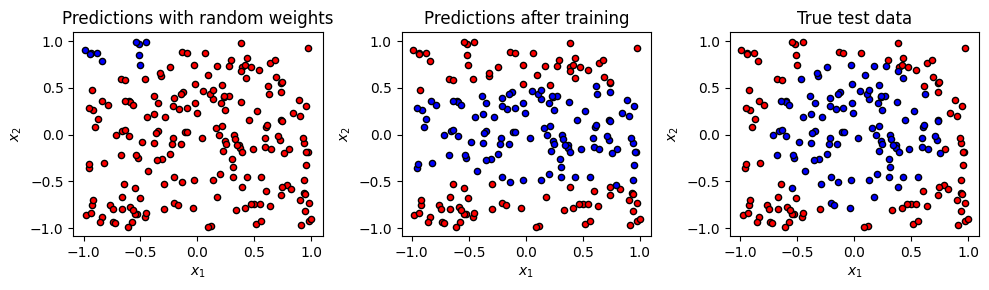

In [32]:
print(
    "Cost: {:3f} | Train accuracy {:3f} | Test Accuracy : {:3f}".format(
        loss, accuracy_train, accuracy_test
    )
)

print("Learned weights")
for i in range(num_layers):
    print("Layer {}: {}".format(i, params[i]))


fig, axes = plt.subplots(1, 3, figsize=(10, 3))
plot_data(X_test, initial_predictions, fig, axes[0])
plot_data(X_test, predicted_test, fig, axes[1])
plot_data(X_test, y_test, fig, axes[2])
axes[0].set_title("Predictions with random weights")
axes[1].set_title("Predictions after training")
axes[2].set_title("True test data")
plt.tight_layout()
plt.show()

# Hypercubic Data

In [33]:
from sklearn.datasets import make_classification

n_samples = 500
n_features = 3
n_informative = 3
n_classes = 2

num_layers = 10
learning_rate = 0.6
epochs = 10
batch_size = 32

    
    # n_samples = 500
    # n_features = 6
    # n_informative = 2
    # n_redundant = 4
    # n_classes = 2

# Create a synthetic dataset with 2 classes
X, y = make_classification(
    n_samples=n_samples,
    n_features=n_features,
    n_informative=n_informative,
    n_redundant=(n_features - n_informative),
    n_classes=n_classes,
    class_sep=2.,
    random_state=0
)

# X = np.array(X)
# y = np.array(y)

# set training and test data
split = int(0.8 * n_samples)
X_train = X[:split, :]
y_train = y[:split]
X_test = X[split:, :]
y_test = y[split:]

In [34]:

# Train using Adam optimizer and evaluate the classifier
num_layers = 3
learning_rate = 0.6
epochs = 5
batch_size = 32

opt = NesterovMomentumOptimizer(stepsize=0.1, momentum=0.9)

# initialize random weights
params = np.random.uniform(size=(num_layers, 2, n_features), requires_grad=True)

predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
accuracy_train = accuracy_score(y_train, predicted_train)

predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
accuracy_test = accuracy_score(y_test, predicted_test)

# save predictions with random weights for comparison
initial_predictions = predicted_test

loss = cost(params, X_test, y_test, state_labels)

print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        0, loss, accuracy_train, accuracy_test
    )
)

for it in range(epochs):
    for Xbatch, ybatch in iterate_minibatches(X_train, y_train, batch_size=batch_size):
        params, _, _, _ = opt.step(cost, params, Xbatch, ybatch, state_labels)

    predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
    accuracy_train = accuracy_score(y_train, predicted_train)
    loss = cost(params, X_train, y_train, state_labels)

    predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
    accuracy_test = accuracy_score(y_test, predicted_test)
    res = [it + 1, loss, accuracy_train, accuracy_test]
    print(
        "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
            *res
        )
    )

Epoch:  0 | Cost: 0.377281 | Train accuracy: 0.485000 | Test Accuracy: 0.410000
Epoch:  1 | Loss: 0.189987 | Train accuracy: 0.717500 | Test accuracy: 0.710000
Epoch:  2 | Loss: 0.063587 | Train accuracy: 0.945000 | Test accuracy: 0.950000
Epoch:  3 | Loss: 0.053696 | Train accuracy: 0.947500 | Test accuracy: 0.960000
Epoch:  4 | Loss: 0.051481 | Train accuracy: 0.955000 | Test accuracy: 0.960000
Epoch:  5 | Loss: 0.048918 | Train accuracy: 0.947500 | Test accuracy: 0.970000


# High-dimensional Annulus

In [35]:
import pandas as pd
import plotly.express as px


def annulus(samples, dimensions, inner_radius=1.0, outer_radius=2.0):
    """
    Generates an n-dimensional dataset of points with 1/0 labels inside an annulus.

    Args:
        samples (int): number of samples to generate
        dimensions (int): number of dimensions for the dataset
        center (array): center of the annulus
        inner_radius (float): inner radius of the annulus
        outer_radius (float): outer radius of the annulus

    Returns:
        Xvals (array): coordinates of points
        yvals (array): classification labels
    """
    Xvals, yvals = [], []
    center = np.zeros(dimensions)
    
    for i in range(samples):
        x = 2 * (np.random.rand(dimensions)) - 1
        y = 0
        distance_to_center = np.linalg.norm(x - center)
        
        if inner_radius < distance_to_center < outer_radius:
            y = 1
        
        Xvals.append(x)
        yvals.append(y)

    return np.array(Xvals), np.array(yvals)


samples = 1000
dimensions = 6
X_train, y_train = annulus(samples, dimensions, inner_radius=0.0, outer_radius=0.8)
X_test, y_test = annulus(samples, dimensions, inner_radius=0.0, outer_radius=0.8)

# df = pd.DataFrame(X_train[:, :3], columns=[f'Dimension {i+1}' for i in range(3)])
# df['Label'] = y_train

# # Create an interactive 3D scatter plot
# fig = px.scatter_3d(df, x='Dimension 1', y='Dimension 2', z='Dimension 3', color='Label',
#                     symbol='Label', opacity=0.5, title='3D Annulus Dataset')

# # Show the plot
# fig.show()

In [36]:
from pennylane.optimize import AdamOptimizer
from pennylane import numpy as np

# Train using Adam optimizer and evaluate the classifier
num_layers = 3
learning_rate = 0.6
epochs = 5
batch_size = 32



opt = NesterovMomentumOptimizer(stepsize=0.1, momentum=0.9)

# initialize random weights
params = np.random.uniform(size=(num_layers, 2, dimensions), requires_grad=True)

predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
accuracy_train = accuracy_score(y_train, predicted_train)

predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
accuracy_test = accuracy_score(y_test, predicted_test)

# save predictions with random weights for comparison
initial_predictions = predicted_test

loss = cost(params, X_test, y_test, state_labels)
# print('loss: ', loss)
# print('accuracy_train: ', accuracy_train)
# print('accuracy_test: ', accuracy_test)

print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        0, loss, accuracy_train, accuracy_test
    )
)

for it in range(epochs):
    for Xbatch, ybatch in iterate_minibatches(X_train, y_train, batch_size=batch_size):
        params, _, _, _ = opt.step(cost, params, Xbatch, ybatch, state_labels)

    predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
    accuracy_train = accuracy_score(y_train, predicted_train)
    loss = cost(params, X_train, y_train, state_labels)

    predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
    accuracy_test = accuracy_score(y_test, predicted_test)
    res = [it + 1, loss, accuracy_train, accuracy_test]

    print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        it+1, loss, accuracy_train, accuracy_test
    )
)

Epoch:  0 | Cost: 0.147858 | Train accuracy: 0.811000 | Test Accuracy: 0.808000
Epoch:  1 | Cost: 0.014650 | Train accuracy: 0.986000 | Test Accuracy: 0.978000
Epoch:  2 | Cost: 0.014170 | Train accuracy: 0.986000 | Test Accuracy: 0.978000
Epoch:  3 | Cost: 0.014036 | Train accuracy: 0.986000 | Test Accuracy: 0.978000
Epoch:  4 | Cost: 0.013976 | Train accuracy: 0.986000 | Test Accuracy: 0.978000
Epoch:  5 | Cost: 0.013936 | Train accuracy: 0.986000 | Test Accuracy: 0.978000


# Hypercubic Clusters 

In [37]:
n_samples = 500
n_features = 6
n_informative = 4
n_classes = 2

num_layers = 10
learning_rate = 0.6
epochs = 10
batch_size = 32

    
    # n_samples = 500
    # n_features = 6
    # n_informative = 2
    # n_redundant = 4
    # n_classes = 2

# Create a synthetic dataset with 2 classes
X, y = make_classification(
    n_samples=n_samples,
    n_features=n_features,
    n_informative=n_informative,
    n_redundant=(n_features - n_informative),
    n_classes=n_classes,
    class_sep=2.,
    random_state=0
)

# X = np.array(X)
# y = np.array(y)

# set training and test data
split = int(0.8 * n_samples)
X_train = X[:split, :]
y_train = y[:split]
X_test = X[split:, :]
y_test = y[split:]


# Train using Adam optimizer and evaluate the classifier
num_layers = 3
learning_rate = 0.6
epochs = 5
batch_size = 32

opt = NesterovMomentumOptimizer(stepsize=0.1, momentum=0.9)

# initialize random weights
params = np.random.uniform(size=(num_layers, 2, n_features), requires_grad=True)

predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
accuracy_train = accuracy_score(y_train, predicted_train)

predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
accuracy_test = accuracy_score(y_test, predicted_test)

# save predictions with random weights for comparison
initial_predictions = predicted_test

loss = cost(params, X_test, y_test, state_labels)

print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        0, loss, accuracy_train, accuracy_test
    )
)

for it in range(epochs):
    for Xbatch, ybatch in iterate_minibatches(X_train, y_train, batch_size=batch_size):
        params, _, _, _ = opt.step(cost, params, Xbatch, ybatch, state_labels)

    predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
    accuracy_train = accuracy_score(y_train, predicted_train)
    loss = cost(params, X_train, y_train, state_labels)

    predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
    accuracy_test = accuracy_score(y_test, predicted_test)
    res = [it + 1, loss, accuracy_train, accuracy_test]
    print(
        "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
            *res
        )
    )

Epoch:  0 | Cost: 0.345989 | Train accuracy: 0.505000 | Test Accuracy: 0.480000
Epoch:  1 | Loss: 0.152482 | Train accuracy: 0.800000 | Test accuracy: 0.690000
Epoch:  2 | Loss: 0.107728 | Train accuracy: 0.872500 | Test accuracy: 0.830000
Epoch:  3 | Loss: 0.078785 | Train accuracy: 0.905000 | Test accuracy: 0.890000
Epoch:  4 | Loss: 0.066352 | Train accuracy: 0.925000 | Test accuracy: 0.900000
Epoch:  5 | Loss: 0.063617 | Train accuracy: 0.937500 | Test accuracy: 0.910000


In [44]:
n_samples = 500
n_features = 9
n_informative = 7
n_classes = 2

num_layers = 10
learning_rate = 0.6
epochs = 10
batch_size = 32

    
    # n_samples = 500
    # n_features = 6
    # n_informative = 2
    # n_redundant = 4
    # n_classes = 2

# Create a synthetic dataset with 2 classes
X, y = make_classification(
    n_samples=n_samples,
    n_features=n_features,
    n_informative=n_informative,
    n_redundant=(n_features - n_informative),
    n_classes=n_classes,
    class_sep=2.,
    random_state=0
)

# X = np.array(X)
# y = np.array(y)

# set training and test data
split = int(0.8 * n_samples)
X_train = X[:split, :]
y_train = y[:split]
X_test = X[split:, :]
y_test = y[split:]


# Train using Adam optimizer and evaluate the classifier
num_layers = 3
learning_rate = 0.6
epochs = 5
batch_size = 32

opt = NesterovMomentumOptimizer(stepsize=0.1, momentum=0.9)

# initialize random weights
params = np.random.uniform(size=(num_layers, 2, n_features), requires_grad=True)

predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
accuracy_train = accuracy_score(y_train, predicted_train)

predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
accuracy_test = accuracy_score(y_test, predicted_test)

# save predictions with random weights for comparison
initial_predictions = predicted_test

loss = cost(params, X_test, y_test, state_labels)

print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        0, loss, accuracy_train, accuracy_test
    )
)

for it in range(epochs):
    for Xbatch, ybatch in iterate_minibatches(X_train, y_train, batch_size=batch_size):
        params, _, _, _ = opt.step(cost, params, Xbatch, ybatch, state_labels)

    predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
    accuracy_train = accuracy_score(y_train, predicted_train)
    loss = cost(params, X_train, y_train, state_labels)

    predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
    accuracy_test = accuracy_score(y_test, predicted_test)
    res = [it + 1, loss, accuracy_train, accuracy_test]
    print(
        "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
            *res
        )
    )

Epoch:  0 | Cost: 0.375886 | Train accuracy: 0.507500 | Test Accuracy: 0.410000
Epoch:  1 | Loss: 0.257639 | Train accuracy: 0.607500 | Test accuracy: 0.580000
Epoch:  2 | Loss: 0.241881 | Train accuracy: 0.637500 | Test accuracy: 0.630000
Epoch:  3 | Loss: 0.228781 | Train accuracy: 0.660000 | Test accuracy: 0.600000
Epoch:  4 | Loss: 0.202276 | Train accuracy: 0.690000 | Test accuracy: 0.650000
Epoch:  5 | Loss: 0.190777 | Train accuracy: 0.707500 | Test accuracy: 0.730000


# JPEG

In [4]:
import cv2
from keras.datasets import mnist
from pennylane import numpy as np


def get_jpeg_data(img, out_length=50):
  # Load the image

  # Convert the image to YCrCb color space
  # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


  # Define the desired size for the subsampled image
  new_width = img.shape[0]//2  # Set to half of the original width
  new_height = img.shape[1]//2  # Set to half of the original height

  # Resize the image to the desired size for subsampling
  subsampled_image = cv2.resize(img, (new_width, new_height))

  # Perform JPEG encoding
  retval, buf = cv2.imencode('.jpg', subsampled_image, [cv2.IMWRITE_JPEG_QUALITY, 10])

  def find_matching_slice(byte_list, target_slice):
      for i in range(len(byte_list) - len(target_slice) + 1):
          if byte_list[i:i + len(target_slice)] == target_slice:
              return i
      return -1

  byte_list = buf.tolist()

  # Define the start and end sequences to search for
  start_sequence = [0xFF, 0xDA]
  end_sequence = [0xFF, 0xD9]

  # Find the starting and ending indices
  start_index = find_matching_slice(byte_list, start_sequence)
  end_index = find_matching_slice(byte_list, end_sequence)

  # Extract the data between start and end sequences
  if start_index != -1 and end_index != -1:
      extracted_data = byte_list[start_index + len(start_sequence):end_index]
      # Convert the extracted data back to a NumPy array if needed
      extracted_data_np = np.array(extracted_data, dtype=np.uint8)

      # Pad to fixed size
      if extracted_data_np.shape[0] < out_length:
        pad_width = out_length - extracted_data_np.shape[0]
        extracted_data_np = np.pad(extracted_data_np, (0, pad_width), mode='constant', constant_values=0)
      if extracted_data_np.shape[0] > out_length:
         extracted_data_np = extracted_data_np[:out_length]
      # print("Extracted data:", extracted_data_np)
      # print("Data Length: ", len(extracted_data_np))
  else:
      print("Start and end sequences not found in the data.")
  return extracted_data_np


# Load the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Resize/subsample images 
sub_dim = 14

train_images_subsampled = np.zeros((train_images.shape[0], sub_dim, sub_dim))
test_images_subsampled = np.zeros((test_images.shape[0], sub_dim, sub_dim))

for i in range(train_images.shape[0]):
    train_images_subsampled[i] = cv2.resize(train_images[i], (sub_dim, sub_dim))
for i in range(test_images.shape[0]):
    test_images_subsampled[i] = cv2.resize(test_images[i], (sub_dim, sub_dim))

    
print('train_images_subsampled.shape: ', train_images_subsampled.shape)
print('test_images_subsampled.shape: ', test_images_subsampled.shape)
# Filter a subset of digits and a fixed number of samples

digits = [0, 1]
train_subset = 500
test_subset = 200

train_filter = np.isin(train_labels, digits)
train_images = train_images_subsampled[train_filter][:train_subset]
train_labels = train_labels[train_filter][:train_subset]

test_filter = np.isin(test_labels, digits)
test_images = test_images_subsampled[test_filter][:test_subset]
test_labels = test_labels[test_filter][:test_subset]
# Convert to JPEG embedding
len_compressed_data = 20
train_images_jpeg = np.zeros((train_images.shape[0], len_compressed_data))
for i in range(len(train_images)):
    train_images_jpeg[i] = get_jpeg_data(train_images[i], len_compressed_data)

test_images_jpeg = np.zeros((test_images.shape[0], len_compressed_data))
for i in range(len(test_images)):
    test_images_jpeg[i] = get_jpeg_data(test_images[i], len_compressed_data)
    
# set training and test data
X_train = train_images.reshape(train_images.shape[0], -1)
y_train = train_labels
X_test = test_images.reshape(test_images.shape[0], -1)
y_test = test_labels

2023-11-29 11:44:26.124400: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-29 11:44:26.202084: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-29 11:44:26.525453: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-29 11:44:26.525484: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-29 11:44:26.527996: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

train_images_subsampled.shape:  (60000, 14, 14)
test_images_subsampled.shape:  (10000, 14, 14)


In [9]:
def train_q_classifier(num_layers = 10, stepsize = 0.1, momentum = 0.9, epochs = 10, batch_size = 32):

    n_qubits = 1
    

    opt = NesterovMomentumOptimizer(stepsize=stepsize, momentum=momentum)

    # initialize random weights
    params = np.random.uniform(size=(num_layers, 2*n_qubits, X_train.shape[1]), requires_grad=True) 


    label_0 = [[1], [0]] # Digit Zero 
    label_1 = [[0], [1]] # Digit One
    state_labels = np.array([label_0, label_1], requires_grad=False)

    predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
    accuracy_train = accuracy_score(y_train, predicted_train)

    predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
    accuracy_test = accuracy_score(y_test, predicted_test)

    loss = cost(params, X_test, y_test, state_labels)

    print(
        "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
            0, loss, accuracy_train, accuracy_test
        )
    )

    for it in range(epochs):
        for Xbatch, ybatch in iterate_minibatches(X_train, y_train, batch_size=batch_size):
            params, _, _, _ = opt.step(cost, params, Xbatch, ybatch, state_labels)

        predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
        accuracy_train = accuracy_score(y_train, predicted_train)
        loss = cost(params, X_train, y_train, state_labels)

        predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
        accuracy_test = accuracy_score(y_test, predicted_test)
        res = [it + 1, loss, accuracy_train, accuracy_test]
        print(
            "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
                *res
            )
        )
        
    return params, float(accuracy_test)

In [11]:
%%time
params, accuracy = train_q_classifier(num_layers=3, stepsize=0.2, epochs=10)
print(f'Accuracy of 2 qubit model with 1 layer: {accuracy}')
print('Parameters: \n', params)

Epoch:  0 | Cost: 0.331355 | Train accuracy: 0.488000 | Test Accuracy: 0.505000
Epoch:  1 | Loss: 0.339676 | Train accuracy: 0.498000 | Test accuracy: 0.470000
Epoch:  2 | Loss: 0.322985 | Train accuracy: 0.540000 | Test accuracy: 0.485000
Epoch:  3 | Loss: 0.335707 | Train accuracy: 0.460000 | Test accuracy: 0.480000
Epoch:  4 | Loss: 0.327092 | Train accuracy: 0.508000 | Test accuracy: 0.530000
Epoch:  5 | Loss: 0.306668 | Train accuracy: 0.546000 | Test accuracy: 0.555000
Epoch:  6 | Loss: 0.328015 | Train accuracy: 0.498000 | Test accuracy: 0.490000
Epoch:  7 | Loss: 0.296877 | Train accuracy: 0.544000 | Test accuracy: 0.500000
Epoch:  8 | Loss: 0.332784 | Train accuracy: 0.504000 | Test accuracy: 0.525000
Epoch:  9 | Loss: 0.327106 | Train accuracy: 0.502000 | Test accuracy: 0.565000
Epoch: 10 | Loss: 0.327094 | Train accuracy: 0.518000 | Test accuracy: 0.530000
Accuracy of 2 qubit model with 1 layer: 0.53
Parameters: 
 [[[ 0.62385932  0.45118488  0.58807208 ...  0.84418315  0.097